# 1.0 Working on Signature Methods

In [1]:
from clustergrammer_widget import *
net = Network(clustergrammer_widget)
df = {}

import clustergrammer_groupby as cby
import gene_exp_10x

In [2]:
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline 

### Load Default Dataset

In [3]:
net.load_file('../data/rc_two_cats.txt')
df['ini'] = net.export_df()
df['ini'].shape

### Drop Gender Category
cols = df['ini'].columns.tolist()
new_cols = []
for inst_col in cols:
    inst_col = list(inst_col)
    new_col = tuple(inst_col[:2])
    new_cols.append(new_col)

df['ini'].columns = new_cols

### Make Dataset with no categories

In [4]:
df['no_cat'] = deepcopy(df['ini'])
cols = df['no_cat'].columns.tolist()
new_cols = []
for inst_col in cols:
    new_col = inst_col[0]
    new_cols.append(new_col)
df['no_cat'].columns = new_cols

In [5]:
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: one', inst_color='red')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: two', inst_color='blue')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: three', inst_color='yellow')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: four', inst_color='black')
net.set_cat_color(axis='col', cat_index=1, cat_name='Category: five', inst_color='purple')

# Visualize Original Dataset

In [6]:
net.load_df(df['ini'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
max_cl = df['ini'].idxmax(axis=1)

# Run with True Categories

In [8]:
df['cat_sig'], keep_genes, keep_genes_dict = cby.generate_signatures(df['ini'], 'Category', pval_cutoff=0.05)
df['pred_cat'], df['sig_sim'], y_info = cby.predict_cats_from_sigs(df['ini'], df['cat_sig'])
df['conf'], populations, ser_correct, fraction_correct = cby.confusion_matrix_and_correct_series(y_info)
print(fraction_correct)

0.827586206897


# Run with no True categories

In [9]:
# df['cat_sig'], keep_genes, keep_genes_dict = cby.generate_signatures(df['ini'], 'Category')
# df['pred_cat'], df['sig_sim'], df['sig_max'], y_info = cby.predict_cats_from_sigs(df['no_cat'], df['cat_sig'])

# Category Signature

In [10]:
net.load_df(df['cat_sig'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### Visualize Informative Dimensions in Original Data
Generate a matrix with only category-informative dimensions/genes.

In [11]:
net.load_df(df['ini'].ix[keep_genes])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


# Predict Category Based on Signature

In [12]:
net.load_df(df['pred_cat'])
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: one', inst_color='red')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: two', inst_color='blue')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: three', inst_color='yellow')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: four', inst_color='black')
net.set_cat_color(axis='col', cat_index=2, cat_name='Predict Category: five', inst_color='purple')

In [13]:
net.load_df(df['pred_cat'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [14]:
net.load_df(df['sig_sim'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [15]:
# net.load_df(df['sig_max'])
# net.cluster()
# net.widget()

### F1 Scores

In [16]:
print(f1_score(y_info['true'], y_info['pred'], average='macro'))
print(f1_score(y_info['true'], y_info['pred'], average='micro'))
print(f1_score(y_info['true'], y_info['pred'], average='weighted'))

0.825734265734
0.827586206897
0.820352061731


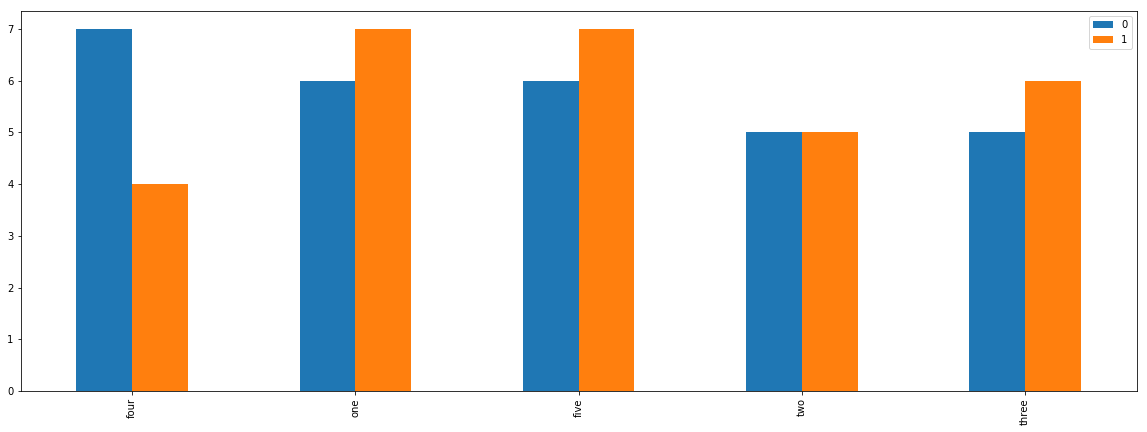

In [17]:
ser_orig_pop = pd.Series(populations['true']).sort_values(ascending=False)
ser_pred_pop = pd.Series(populations['pred']).sort_values(ascending=False)
df['compare_pop'] = pd.concat([ser_orig_pop, ser_pred_pop], axis=1)
df['compare_pop'] = df['compare_pop'].loc[ser_orig_pop.index.tolist()]
df['compare_pop'].plot(kind='bar', figsize=(20,7))

### Visualize confusion matrix

In [18]:
net.load_df(df['conf'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [19]:
real_fraction_correct = deepcopy(fraction_correct)

### Calculate the fraction of correct predictions for each category type

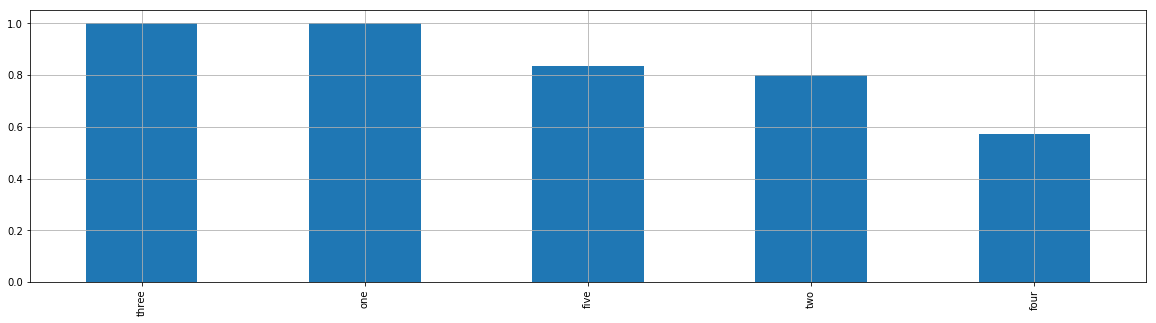

In [20]:
ser_correct.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), grid=True)

# Shuffle Labels and Predict Categories
Run 

In [22]:
num_shuffles = 100
perform_ser = cby.compare_performance_to_shuffled_labels(df['ini'], 'Category', 
                                                         num_shuffles=num_shuffles)
print('mean: ', perform_ser.mean(), 'std: ', perform_ser.std())
print('previously calc real performance: ', real_fraction_correct)

performance (fraction correct) of unshuffled: 0.827586206897
mean:  0.646206896552 std:  0.0964944847001
previously calc real performance:  0.827586206897


In [23]:
real_performance = perform_ser[perform_ser > real_fraction_correct].shape[0]/num_shuffles
print('real labels perform in the top ' + str(real_performance*100) + '% of shuffled labels')

real labels perform in the top 3.0% of shuffled labels


# Compare Similarity of intra vs inter category samples

In [28]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist

In [33]:
df['ini'].shape

(38, 29)

In [58]:
# compute distnace between rows (transpose to get cols as rows)
dist_arr = 1 - pdist(df['ini'].transpose(), metric='cosine')
dist_arr.shape

(406,)

### get sample combinations


In [59]:
from itertools import combinations
sample_combos = list(combinations(range(df['ini'].shape[1]),2))
len(sample_combos)

406

In [60]:
cols[:4]

[('Cell Line: H1650', 'Category: two'),
 ('Cell Line: H23', 'Category: two'),
 ('Cell Line: CAL-12T', 'Category: two'),
 ('Cell Line: H358', 'Category: one')]

In [61]:
sample_combos[:3]

[(0, 1), (0, 2), (0, 3)]

In [152]:
sample_names = [(cols[x[0]][0] + '_' + cols[x[1]][0], cols[x[0]][1], cols[x[1]][1]) for x in sample_combos]

In [153]:
print(sample_names[0])
print(sample_names[1])
print(sample_names[2])

('Cell Line: H1650_Cell Line: H23', 'Category: two', 'Category: two')
('Cell Line: H1650_Cell Line: CAL-12T', 'Category: two', 'Category: two')
('Cell Line: H1650_Cell Line: H358', 'Category: two', 'Category: one')


### get intra-category sample similarities

In [154]:
ser_dist = pd.Series(data=dist_arr, index=sample_names)

In [155]:
pd.__version__

'0.19.2'

In [156]:
ser_dist[0:10]

(Cell Line: H1650_Cell Line: H23, Category: two, Category: two)       -0.079560
(Cell Line: H1650_Cell Line: CAL-12T, Category: two, Category: two)    0.033912
(Cell Line: H1650_Cell Line: H358, Category: two, Category: one)       0.206788
(Cell Line: H1650_Cell Line: H1975, Category: two, Category: two)      0.072484
(Cell Line: H1650_Cell Line: HCC15, Category: two, Category: two)     -0.117417
(Cell Line: H1650_Cell Line: H1355, Category: two, Category: three)   -0.041474
(Cell Line: H1650_Cell Line: HCC827, Category: two, Category: one)     0.191598
(Cell Line: H1650_Cell Line: H2405, Category: two, Category: five)     0.010358
(Cell Line: H1650_Cell Line: HCC78, Category: two, Category: five)     0.045813
(Cell Line: H1650_Cell Line: H1666, Category: two, Category: four)     0.027328
dtype: float64

In [157]:
ser_dist.ix[sample_names[0:2]]

(Cell Line: H1650_Cell Line: H23, Category: two, Category: two)       -0.079560
(Cell Line: H1650_Cell Line: CAL-12T, Category: two, Category: two)    0.033912
dtype: float64

In [163]:
sample_names[1][2]

'Category: two'

In [165]:
# find intra-cat sample comparisons
intra_cat = [x for x in sample_names if x[1] == x[2]]
print(len(intra_cat))

# find inter-cat sample comparisons
inter_cat = [x for x in sample_names if x[1] != x[2]]
print(len(inter_cat))

print(len(intra_cat) + len(inter_cat))

71
335
406


In [166]:
print(len(intra_cat))
print(ser_dist[intra_cat].shape)

71
(71,)


In [175]:
ser_same = ser_dist[intra_cat]
ser_same.name = 'Same Category'
ser_diff = ser_dist[inter_cat]
ser_diff.name = 'Different Category'
print(ser_same.shape, ser_diff.shape)

(71,) (335,)


In [176]:
ser_same.mean()

0.1259335031728058

In [177]:
ser_diff.mean()

0.014070877194372661

In [184]:
df['sim_cats'] = pd.DataFrame([ser_same, ser_diff]).transpose()
df['sim_cats'].shape

(406, 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1261ab390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1263a1c18>]], dtype=object)

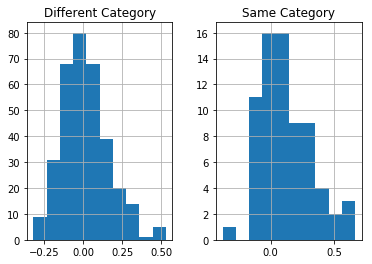

In [185]:
df['sim_cats'].hist()

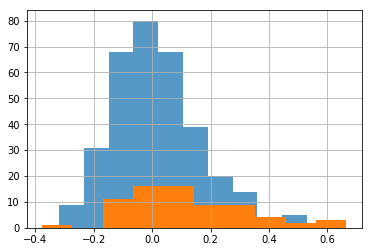

In [191]:
ser_diff.hist(alpha=0.75)
ser_same.hist(alpha=1.0)